In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news-large-dataset-70000/WELFake_Dataset.csv


In [2]:
import numpy as np
import pandas as pd
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('popular')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /usr/share/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /usr/share/n

# Data-Preporcessing

In [3]:
#loading the data
news = pd.read_csv("/kaggle/input/fake-news-large-dataset-70000/WELFake_Dataset.csv")

In [4]:
news.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
news = news.head(10000)

In [6]:
news = news.rename(columns = {"Unnamed: 0":"id"})

In [7]:
news.head()

,id,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [8]:
#checking the null values
news.isnull().sum()

id        0
title    65
text      8
label     0
dtype: int64

In [9]:
news = news.fillna("")

In [10]:
#joining title and text data in the content column
news['content'] = news['title']+' '+news['text']

In [11]:
news.head()

,id,title,text,label,content
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...


In [12]:
#seperating the data and label

X = news.drop('label', axis = 1)
Y = news['label']

In [13]:
print(X)
print(Y)

        id                                              title  \
0        0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1        1                                                      
2        2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3        3  Bobby Jindal, raised Hindu, uses story of Chri...   
4        4  SATAN 2: Russia unvelis an image of its terrif...   
...    ...                                                ...   
9995  9995  Yemen's Saleh ready to turn new page if Saudi-...   
9996  9996  Anonymous Hacker Fighting For Justina Pelletie...   
9997  9997  Hot-Air Balloon Crash in Texas Kills 16, Offic...   
9998  9998  Palme d’Or Goes to a Ken Loach Film at Cannes ...   
9999  9999  Mike Pence won the debate by throwing Donald T...   

                                                   text  \
0     No comment is expected from Barack Obama Membe...   
1        Did they post their votes for Hillary already?   
2      Now, most of the demonstrators gath

## Performing Stemming

In [14]:
ps = PorterStemmer()

In [15]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-z]',' ',content) 
  stemmed_content = stemmed_content.lower() 
  stemmed_content = stemmed_content.split() 
  stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content) 
  return stemmed_content

In [16]:
news['content'] = news['content'].apply(stemming)


In [17]:
print(news['content'])

0       law enforc high alert follow threat cop white ...
1                               post vote hillari alreadi
2       unbeliev obama attorney gener say charlott rio...
3       bobbi jindal rais hindu use stori christian co...
4       satan russia unv imag terrifi new supernuk wes...
                              ...                        
9995    yemen saleh readi turn new page saudi led atta...
9996    anonym hacker fight justina pelleti plead guil...
9997    hot air balloon crash texa kill offici say new...
9998    palm goe ken loach film cann new york time can...
9999    mike penc debat throw donald trump bu republic...
Name: content, Length: 10000, dtype: object


In [18]:
X = news['content'].values
Y = news['label']

In [19]:
print(X)
print(Y)

['law enforc high alert follow threat cop white blacklivesmatt fyf terrorist [video] comment expect barack obama member fyf fukyoflag blacklivesmatt movement call lynch hang white peopl cop encourag other radio show tuesday night turn tide kill white peopl cop send messag kill black peopl america one f yoflag organ call sunshin radio blog show host texa call sunshin f ing opinion radio show snapshot fyf lolatwhitefear twitter page p show urg support call fyf tonight continu dismantl illus white snapshot twitter radio call invit fyf radio show air p eastern standard time show caller clearli call lynch kill white peopl minut clip radio show heard provid breitbart texa someon would like refer hannib alreadi receiv death threat result interrupt fyf confer call unidentifi black man said mother f ker start f ing like us bunch ni er takin one us roll said caus alreadi roll gang anyway six seven black mother f cker see white person lynch ass let turn tabl conspir cop start lose peopl state eme

In [20]:
vector = TfidfVectorizer()

X = vector.fit_transform(X)

# Starting to train the model

In [21]:
#splitting the data into train and test split
X_train,X_test,y_train,y_test = train_test_split(X,Y, stratify=Y, test_size=0.25, random_state=2)

In [22]:
#Instantiating the models
modelL = LogisticRegression()
modelR = RandomForestRegressor(n_estimators=50, random_state=42)
modelS = SVC()
modelD = DecisionTreeRegressor()

## Training different models for highest accuracy

In [23]:
#Fitting the data into the models
modelL.fit(X_train, y_train)
modelR.fit(X_train, y_train)
modelS.fit(X_train, y_train)
modelD.fit(X_train, y_train)

DecisionTreeRegressor()

## Evaluation of Logistic Regression

In [24]:
X_train_predictionL =  modelL.predict(X_train)
acc_trainL = accuracy_score(X_train_predictionL, y_train)
X_test_predictionL =  modelL.predict(X_test)
acc_testL = accuracy_score(X_test_predictionL, y_test)

print("Accuracy score on training data:",acc_trainL)
print("Accuracy score on testing data:",acc_testL)

Accuracy score on training data: 0.9534666666666667
Accuracy score on testing data: 0.898


## Evaluation of Decision Trees

In [25]:
X_train_predictionD =  modelD.predict(X_train)
acc_trainD = accuracy_score(X_train_predictionD, y_train)
X_test_predictionD =  modelD.predict(X_test)
acc_testD = accuracy_score(X_test_predictionD, y_test)

print("Accuracy score on training data:",acc_trainD)
print("Accuracy score on testing data:",acc_testD)

Accuracy score on training data: 1.0
Accuracy score on testing data: 0.9092


## Evaluation of SVM

In [26]:
X_train_predictionS =  modelS.predict(X_train)
acc_trainS = accuracy_score(X_train_predictionS, y_train)
X_test_predictionS =  modelS.predict(X_test)
acc_testS = accuracy_score(X_test_predictionS, y_test)

print("Accuracy score on training data:",acc_trainS)
print("Accuracy score on testing data:",acc_testS)

Accuracy score on training data: 0.9952
Accuracy score on testing data: 0.9156


## Evaluation of Random Forest

In [27]:
X_train_predictionR = modelR.predict(X_train)

# Round predictions to the nearest integer (0 or 1)
X_train_predictionR = np.round(X_train_predictionR)
acc_trainR = accuracy_score(X_train_predictionR, y_train)

X_test_predictionR = modelR.predict(X_test)

# Round predictions to the nearest integer (0 or 1)
X_test_predictionR = np.round(X_test_predictionR)
acc_testR = accuracy_score(X_test_predictionR, y_test)

print("Accuracy score on training data:",acc_trainR)
print("Accuracy score on testing data:",acc_testR)

Accuracy score on training data: 0.9997333333333334
Accuracy score on testing data: 0.9396


# Making a Predictive System

In [29]:
X_test.shape

(2500, 59353)

In [30]:
n=1200
X_new = X_test[n] #means the first row/news

prediction_final = modelD.predict(X_new)
# prediction_final = int(np.round(prediction_final[0])) #becoz we're using Random Forest else comment out.

if prediction_final[0] == 0:
# if prediction_final == 1: #becoz we're using Random Forest else comment out., use above one for others
  print('The news is Real')
else:
  print('The news is Fake')

check = y_test.iloc[n]  #!!best practice to use iloc
# print(check)

if check==prediction_final[0]:
  print("Correct Prediction")
else:
  print("Wrong Prediction")

The news is Fake
Correct Prediction


# Model Performance Comparison

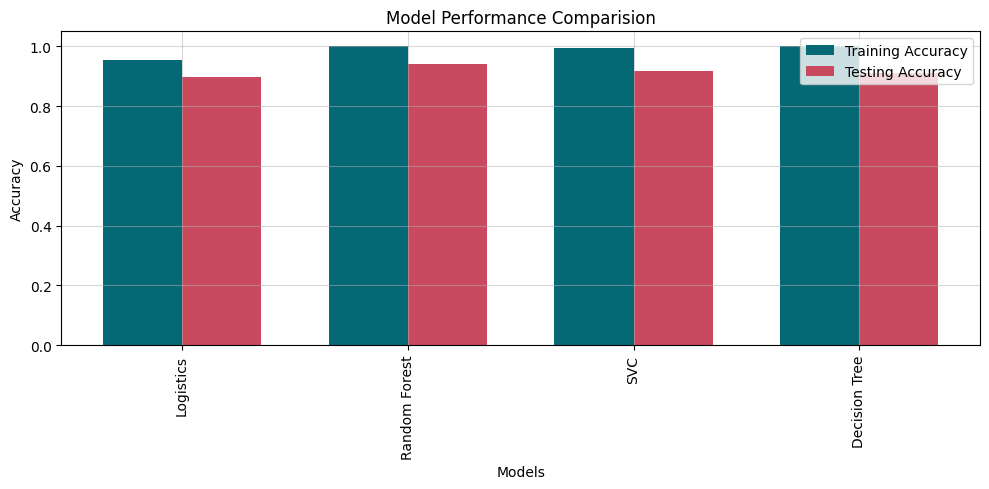

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

models = ['Logistics', 'Random Forest', 'SVC', 'Decision Tree']
train_accuracies = [acc_trainL, acc_trainR, acc_trainS, acc_trainD]
test_accuracies = [acc_testL, acc_testR, acc_testS, acc_testD]

x = np.arange(len(models))
width = 0.35

plt.bar(x-width/2, train_accuracies, width, label='Training Accuracy', color='#056875')
plt.bar(x+width/2, test_accuracies, width, label='Testing Accuracy', color='#C9495E')

plt.xlabel('Models')
plt.ylabel('Accuracy', rotation=90)
plt.title('Model Performance Comparision')
plt.xticks(x,models,rotation=90)
plt.legend()
plt.grid(True,alpha=0.5)
plt.tight_layout()
plt.show()